<a href="https://colab.research.google.com/github/Nazneen-akram/NED-DL-Assignments/blob/main/PSX_stocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
#!pip install psx-data-reader

In [1]:
import datetime, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from tensorflow import keras
from keras.layers import Input, LSTM, Dropout, GRU, Dense
from keras.models import Model


from psx import stocks, tickers

In [7]:


print(dir(psx))

['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '__version__']


In [2]:
#tickers = tickers()

symbol = 'EXIDE'
start = datetime.date(2018, 1, 1)

current_date = datetime.date.today()
current_hour = datetime.datetime.now().hour
# Check if it's a weekday and the time is before 6 PM
if current_date.weekday() < 5 and current_hour < 18:
    end = current_date - datetime.timedelta(days=1) # If yes, set end to the previous date
else:
    end = current_date # Otherwise, use the current date

# Check if the difference between end and start is less than 2 years
if (end - start).days < 365 * 2:
    print("Please increase interval to more than 2 years")
    #sys.exit()

data = stocks(symbol, start=start, end=end)

print(f"Ticker data for {symbol} downloaded successfully.")
print("End Date:", end)

Ticker data for EXIDE downloaded successfully.
End Date: 2024-01-14


In [3]:
# creatin a new column named Avg which will be used as input data
data = data.sort_values('Date')
data['Avg'] = np.mean(data[['Open', 'Close']], axis=1)
data.tail()

,Open,High,Low,Close,Volume,Avg
Date,,,,,,
2024-01-08,405.00,425.00,405.00,405.79,26100.0,405.395
2024-01-09,405.01,412.50,404.04,409.15,15000.0,407.080
2024-01-10,409.20,439.84,409.20,439.84,79700.0,424.520
2024-01-11,448.68,450.00,430.00,435.01,47300.0,441.845
2024-01-12,436.00,439.00,426.50,430.10,16900.0,433.050


In [4]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create subplots with shared x-axis
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.1, subplot_titles=(symbol, 'Volume'))

# Add candlestick chart to the first subplot
candlestick = go.Candlestick(x=data.index,
                             open=data['Open'],
                             high=data['High'],
                             low=data['Low'],
                             close=data['Close'],
                             name='Candlestick')
fig.add_trace(candlestick, row=1, col=1)

# Add volume bars to the second subplot
volume_bars = go.Bar(x=data.index, y=data['Volume'], marker_color="blue", name='Volume')
fig.add_trace(volume_bars, row=2, col=1)

# Update layout
fig.update_layout(title=f"{symbol} Stocks",
                  yaxis_title="Price (PKR)",
                  width=1200,
                  height=700)

# Hide the x-axis rangeslider
fig.update(layout_xaxis_rangeslider_visible=False)

# Show the plot
fig.show()


Selecting 'Avg' as the base data for training and inference

In [5]:
D = data[['Avg']]   # put only 'Avg' values in array 'D'

D.tail()

,Avg
Date,
2024-01-08,405.395
2024-01-09,407.080
2024-01-10,424.520
2024-01-11,441.845
2024-01-12,433.050


In [6]:
loop_back = 100
X, y = [], []

for i in range(len(D)-loop_back):
    X0, Xn, yn = i, i+loop_back, i+loop_back
    X_slice = D.iloc[X0:Xn, 0].values  #setting 'seq_len' prior values as predictor
    y_slice = D.iloc[yn, 0]            #setting next-to-predictor value as lable
    X.append(X_slice)
    y.append(y_slice)

X = np.array(X)
y = np.array(y)

In [11]:
X

array([[405.5  , 409.4  , 412.5  , ..., 389.   , 380.05 , 378.005],
       [409.4  , 412.5  , 429.385, ..., 380.05 , 378.005, 382.5  ],
       [412.5  , 429.385, 438.5  , ..., 378.005, 382.5  , 383.125],
       ...,
       [381.295, 366.59 , 356.84 , ..., 402.12 , 405.395, 407.08 ],
       [366.59 , 356.84 , 347.5  , ..., 405.395, 407.08 , 424.52 ],
       [356.84 , 347.5  , 348.45 , ..., 407.08 , 424.52 , 441.845]])

In [10]:
y

array([382.5  , 383.125, 386.35 , ..., 424.52 , 441.845, 433.05 ])

In [8]:
split = 365 #if D.shape[0] > 365*2 else int(D.shape[0]/2)

X_train, y_train = X[:-split], y[:-split]
X_test,  y_test  = X[-split:], y[-split:]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(964, 100) (964,) (365, 100) (365,)


In [12]:
X_scaler = MinMaxScaler(feature_range=(0,1))
X_train_scaled = X_scaler.fit_transform(X_train)
X_test_scaled  = X_scaler.transform(X_test)

y_scaler = MinMaxScaler(feature_range=(0,1))
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1))#.reshape(-1)
y_test_scaled  = y_scaler.transform(y_test.reshape(-1, 1))#.reshape(-1)

In [13]:
X_train_scaled.shape, X_test_scaled.shape, y_train_scaled.shape, y_test_scaled.shape

((964, 100), (365, 100), (964, 1), (365, 1))

In [14]:
X_train_scaled_3d = np.reshape(X_train_scaled, (-1, X_train_scaled.shape[1], 1))
X_test_scaled_3d  = np.reshape(X_test_scaled,  (-1, X_test_scaled.shape[1], 1))

In [15]:
X_train_scaled_3d.shape, X_test_scaled_3d.shape, y_train_scaled.shape, y_test_scaled.shape

((964, 100, 1), (365, 100, 1), (964, 1), (365, 1))

In [16]:
# Input layer
input_shape = (X_train_scaled_3d.shape[1], X_train_scaled_3d.shape[2])  # skipping sequencing axis
inputs = Input(shape=input_shape)

# LSTM layer with return_sequences=True
x = LSTM(units=50, return_sequences=True)(inputs)
x = Dropout(0.1)(x)

# LSTM layer with return_sequences=True
x = LSTM(units=50, return_sequences=True)(x)
x = Dropout(0.2)(x)

# GRU layer
x = GRU(units=50)(x)
x = Dropout(0.2)(x)

# Output layer
outputs = Dense(units=1)(x)

# Creating the functional model
model = Model(inputs=inputs, outputs=outputs)

In [17]:
from keras.optimizers import Adam
from keras.losses import mse

adam_optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=adam_optimizer, loss=mse)

In [18]:
model.fit(X_train_scaled_3d, y_train_scaled, epochs=20, batch_size=32)

Epoch 1/20
31/31 [==============================] - 8s 17ms/step - loss: 0.0252
Epoch 2/20
31/31 [==============================] - 0s 14ms/step - loss: 0.0066
Epoch 3/20
31/31 [==============================] - 0s 13ms/step - loss: 0.0061
Epoch 4/20
31/31 [==============================] - 0s 14ms/step - loss: 0.0053
Epoch 5/20
31/31 [==============================] - 0s 13ms/step - loss: 0.0047
Epoch 6/20
31/31 [==============================] - 0s 13ms/step - loss: 0.0040
Epoch 7/20
31/31 [==============================] - 0s 14ms/step - loss: 0.0042
Epoch 8/20
31/31 [==============================] - 0s 13ms/step - loss: 0.0044
Epoch 9/20
31/31 [==============================] - 0s 13ms/step - loss: 0.0036
Epoch 10/20
31/31 [==============================] - 0s 13ms/step - loss: 0.0036
Epoch 11/20
31/31 [==============================] - 1s 18ms/step - loss: 0.0034
Epoch 12/20
31/31 [==============================] - 1s 26ms/step - loss: 0.0035
Epoch 13/20
31/31 [==================

In [19]:
y_pred = model.predict(X_test_scaled_3d)

12/12 [==============================] - 2s 15ms/step


In [21]:
rmse = np.sqrt(np.mean((y_pred - y_test_scaled)**2))
rmse*100

3.149413115508238

### de-normalization of the test and predicted values (conversion in PKR)

In [22]:
rmse_denormalized = y_scaler.inverse_transform(rmse.reshape(-1, 1)).flatten()   #inverse transform expects column data, scaler expects 1D
rmse_denormalized

array([78.99955651])

In [23]:
y_pred = np.reshape(y_pred, y_test_scaled.shape) # conversin to same shape y_test_scaled

y_test_scaled.shape, y_pred.shape

((365, 1), (365, 1))

In [24]:
# Denormalization using inverse_transform
y_true_denormalized = y_scaler.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()   #inverse transform expects column data, scaler expects 1D
y_pred_denormalized = y_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

In [25]:
y_true_denormalized.shape, y_pred_denormalized.shape

((365,), (365,))

In [26]:
#verifying last value of y_true & y_pred
y_true_denormalized[-1], y_pred_denormalized[-1]

(433.05, 420.33734)

Packing the data in a dataframe with index value

In [27]:
# Create a DataFrame named 'display'
display = pd.DataFrame(index=D[-split:].index)
display['y_true'] = y_true_denormalized
display['y_pred'] = y_pred_denormalized

display.tail()

,y_true,y_pred
Date,,
2024-01-08,405.395,396.386993
2024-01-09,407.080,400.670563
2024-01-10,424.520,405.571472
2024-01-11,441.845,411.855438
2024-01-12,433.050,420.337341


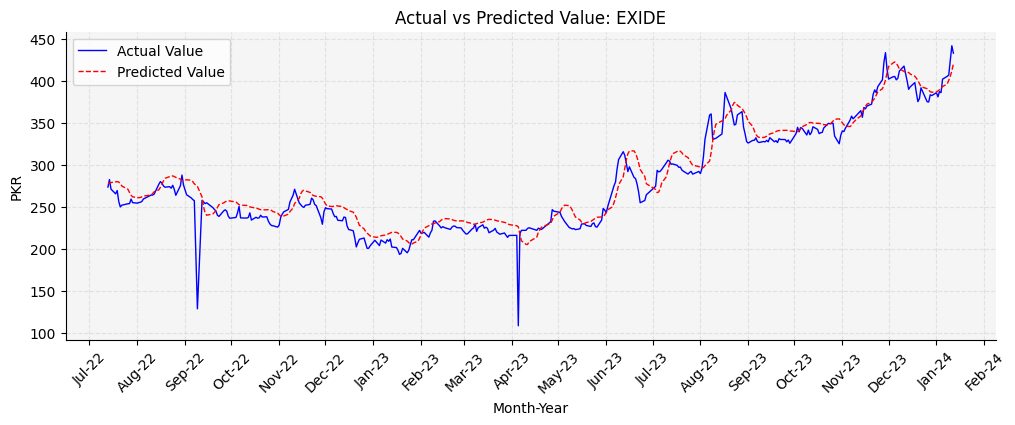

In [28]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Increase DPI for better resolution
plt.rcParams['figure.dpi'] = 100

# Create a Matplotlib figure and axis
fig, ax = plt.subplots(figsize=(12, 4))

# Plot 'y_true' and 'y_pred' with fine lines
ax.plot(display.index, display['y_true'], label='Actual Value', color='blue', linewidth=1, linestyle='-')
ax.plot(display.index, display['y_pred'], label='Predicted Value', color='red', linewidth=1, linestyle='--')

# Customize appearance
ax.set(xlabel='Month-Year', ylabel='PKR', title=f'Actual vs Predicted Value: {symbol}')
ax.legend(loc='upper left')
plt.xticks(rotation=45)

# Customize x-axis date format
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))

# Set a light background color
ax.set_facecolor('#F5F5F5')

# Set a light grid color
ax.grid(True, linestyle='--', alpha=0.7, color='#D9D9D9')

# Remove top and right spines for aesthetics
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Show the plot
plt.show()
